In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 256

# Data

In [3]:
train = FashionMNIST('./data/fashion', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data/fashion', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

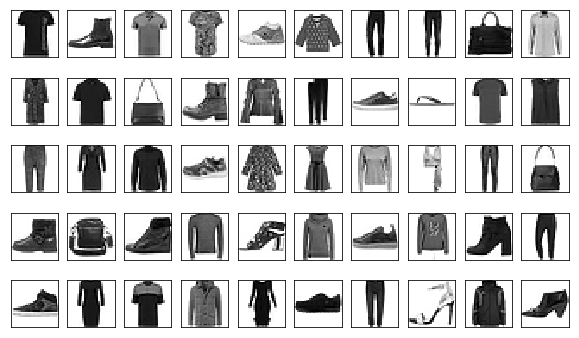

In [35]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray_r')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=256):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//4, kernel_size=6, stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//3)
        self.conv3 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel//2)
        self.conv4 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv5 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x):
        h1: Variable = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2: Variable = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3: Variable = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4: Variable = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        
        # Global Average Pooling
        h5 = F.leaky_relu(self.conv5(h4), negative_slope=0.2)
        gap = F.avg_pool2d(h5, kernel_size=h5.size()[2:]).view(h5.size()[0], -1)
        output = F.sigmoid(gap)
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator(
  (conv1): Conv2d (1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (64, 85, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (85, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=64):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*16)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*16, _c*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*8)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*8, _c*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*4)
        
        self.tp_conv4 = nn.ConvTranspose2d(_c*4, _c*2, kernel_size=4, stride=1, padding=2, bias=False)
        self.bn4 = nn.BatchNorm2d(_c*2)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c*2, _c, kernel_size=4, stride=2, padding=2, bias=False)
        self.bn5 = nn.BatchNorm2d(_c)
        
        self.tp_conv6 = nn.ConvTranspose2d(_c, 1, kernel_size=5, stride=1, padding=2, bias=False)
    
    def forward(self, noise):
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())
        
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
#         print('h4', h.size())
        
        h = self.tp_conv5(h)
        h = F.relu(self.bn5(h))
#         print('h5', h.size())
        
        h = self.tp_conv6(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator(
  (tp_conv1): ConvTranspose2d (100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv6): ConvTranspose2d (64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)


## Load Model

In [ ]:
import os

def load_model(file='dcgan.pth.tar'):
    divergences, d_losses, g_losses, d_fake_losses, d_real_losses = None, None, None, None, None
    if os.path.exists(file):
        checkpoint = torch.load('dcgan.pth.tar')
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer'])

        divergences = checkpoint['divergence']
        d_losses = checkpoint['d_losses']
        g_losses = checkpoint['g_losses']
        d_fake_losses = checkpoint['d_fake_losses']
        d_real_losses = checkpoint['d_real_losses']
    return divergences, d_losses, g_losses, d_fake_losses, d_real_losses
divergences, d_losses, g_losses, d_fake_losses, d_real_losses = load_model()

# Train

In [9]:
N_EPOCH = 600

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [12]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_pred = D(G(noise))
        g_loss = loss_f(y_pred, real_y[:_batch_size])
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
    print()

[1/600] divergence: 0.651    D: 0.52     D_real: 0.426    D_fake: 0.52     G:1.32    
[2/600] divergence: 0.832    D: 0.247    D_real: 0.216    D_fake: 0.247    G:3.24    
[3/600] divergence: 0.937    D: 0.082    D_real: 0.12     D_fake: 0.082    G:4.09    
[4/600] divergence: 0.933    D: 0.0861   D_real: 0.146    D_fake: 0.0861   G:4.05    
[5/600] divergence: 0.972    D: 0.0358   D_real: 0.0515   D_fake: 0.0358   G:4.45    
[6/600] divergence: 0.973    D: 0.0518   D_real: 0.0266   D_fake: 0.0518   G:4.98    
[7/600] divergence: 0.95     D: 0.0745   D_real: 0.0902   D_fake: 0.0745   G:4.74    
[8/600] divergence: 0.919    D: 0.103    D_real: 0.121    D_fake: 0.103    G:3.84    
[9/600] divergence: 0.905    D: 0.14     D_real: 0.103    D_fake: 0.14     G:3.65    
[10/600] divergence: 0.912    D: 0.129    D_real: 0.111    D_fake: 0.129    G:3.88    
[11/600] divergence: 0.904    D: 0.136    D_real: 0.15     D_fake: 0.136    G:3.61    
[12/600] divergence: 0.897    D: 0.146    D_real: 0.

[188/600] divergence: 0.796    D: 0.3      D_real: 0.319    D_fake: 0.3      G:2.2     
[189/600] divergence: 0.791    D: 0.315    D_real: 0.352    D_fake: 0.315    G:2.3     
[190/600] divergence: 0.776    D: 0.326    D_real: 0.397    D_fake: 0.326    G:2.12    
[191/600] divergence: 0.761    D: 0.35     D_real: 0.447    D_fake: 0.35     G:1.97    
[192/600] divergence: 0.77     D: 0.36     D_real: 0.371    D_fake: 0.36     G:2.0     
[193/600] divergence: 0.78     D: 0.352    D_real: 0.352    D_fake: 0.352    G:2.08    
[194/600] divergence: 0.783    D: 0.353    D_real: 0.355    D_fake: 0.353    G:2.33    
[195/600] divergence: 0.787    D: 0.339    D_real: 0.296    D_fake: 0.339    G:2.32    
[196/600] divergence: 0.778    D: 0.343    D_real: 0.317    D_fake: 0.343    G:2.17    
[197/600] divergence: 0.789    D: 0.321    D_real: 0.331    D_fake: 0.321    G:2.24    
[198/600] divergence: 0.8      D: 0.298    D_real: 0.321    D_fake: 0.298    G:2.25    
[199/600] divergence: 0.804    D

[374/600] divergence: 0.917    D: 0.134    D_real: 0.153    D_fake: 0.134    G:3.63    
[375/600] divergence: 0.931    D: 0.103    D_real: 0.162    D_fake: 0.103    G:3.74    
[376/600] divergence: 0.931    D: 0.0961   D_real: 0.111    D_fake: 0.0961   G:3.75    
[377/600] divergence: 0.924    D: 0.125    D_real: 0.0926   D_fake: 0.125    G:3.84    
[378/600] divergence: 0.923    D: 0.131    D_real: 0.11     D_fake: 0.131    G:3.83    
[379/600] divergence: 0.924    D: 0.116    D_real: 0.164    D_fake: 0.116    G:3.73    
[380/600] divergence: 0.915    D: 0.144    D_real: 0.211    D_fake: 0.144    G:3.84    
[381/600] divergence: 0.91     D: 0.157    D_real: 0.17     D_fake: 0.157    G:3.91    
[382/600] divergence: 0.911    D: 0.145    D_real: 0.124    D_fake: 0.145    G:3.83    
[383/600] divergence: 0.913    D: 0.156    D_real: 0.146    D_fake: 0.156    G:3.9     
[384/600] divergence: 0.913    D: 0.167    D_real: 0.157    D_fake: 0.167    G:3.89    
[385/600] divergence: 0.921    D

[560/600] divergence: 0.953    D: 0.0857   D_real: 0.0536   D_fake: 0.0857   G:4.88    
[561/600] divergence: 0.954    D: 0.0779   D_real: 0.0788   D_fake: 0.0779   G:5.08    
[562/600] divergence: 0.953    D: 0.0768   D_real: 0.106    D_fake: 0.0768   G:4.89    
[563/600] divergence: 0.952    D: 0.08     D_real: 0.0904   D_fake: 0.08     G:4.76    
[564/600] divergence: 0.95     D: 0.0835   D_real: 0.0811   D_fake: 0.0835   G:4.87    
[565/600] divergence: 0.948    D: 0.083    D_real: 0.061    D_fake: 0.083    G:4.9     
[566/600] divergence: 0.947    D: 0.0834   D_real: 0.0714   D_fake: 0.0834   G:4.74    
[567/600] divergence: 0.953    D: 0.0701   D_real: 0.0687   D_fake: 0.0701   G:4.52    
[568/600] divergence: 0.951    D: 0.0738   D_real: 0.0793   D_fake: 0.0738   G:4.49    
[569/600] divergence: 0.955    D: 0.0686   D_real: 0.0936   D_fake: 0.0686   G:4.66    
[570/600] divergence: 0.955    D: 0.074    D_real: 0.0961   D_fake: 0.074    G:4.7     
[571/600] divergence: 0.956    D

## Save Model

In [ ]:
def save_moodel():
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'g_optimizer': g_optimizer.state_dict(),
                   'd_optimizer': d_optimizer.state_dict(),
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    torch.save(check_point, 'dcgan-test.pth.tar')
save_moodel()

## Loss Visualization

In [13]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

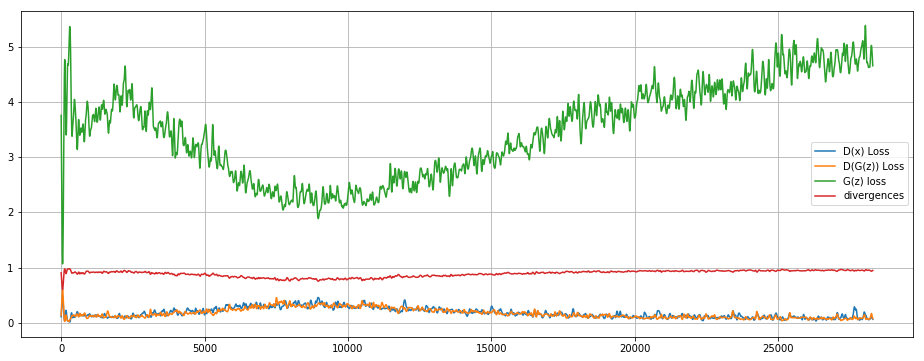

In [14]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

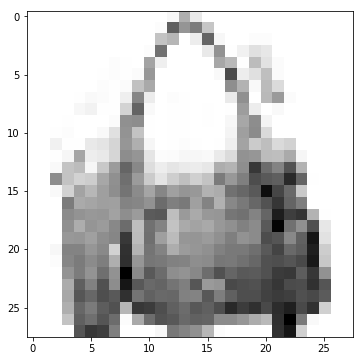

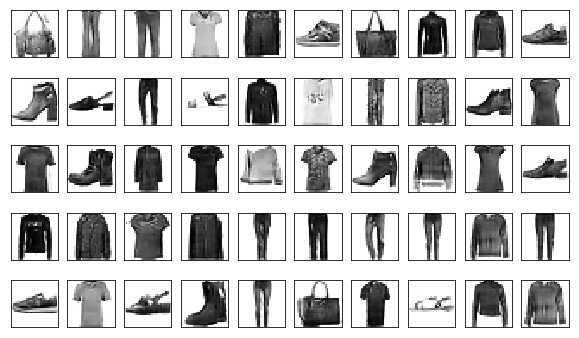

In [38]:
noise = Variable(torch.randn((128, 100, 1, 1)).cuda())
images = G(noise).view((-1, 28, 28)).data.cpu().numpy()
images = (images * 255).astype(np.uint8)
imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1